In [3]:
! pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"sonalraj1234","key":"7a64f1d66d8ab0f686322afd219f61aa"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

In [8]:
BASE_PATH = '/content/crop_part1'

In [9]:
import os
from tqdm import tqdm
age = []
gender = []
image_name = []

for name in (os.listdir(BASE_PATH)):
    split = name.split("_")
#     print(split)
    age.append(split[0])
    gender.append(split[1])
    image_name.append(name)

In [10]:
from PIL import Image

# Open an image file
image = Image.open('/content/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg')

# Get the size of the image
width, height = image.size
print(f"Width: {width}, Height: {height}")


Width: 200, Height: 200


In [11]:
import pandas as pd

df = pd.DataFrame({'age' : age, 'gender' : gender, 'img' : image_name})

df.head()

,age,gender,img
0,42,0,42_0_4_20170104174008963.jpg.chip.jpg
1,1,1,1_1_4_20170103210113314.jpg.chip.jpg
2,46,0,46_0_0_20170104203859666.jpg.chip.jpg
3,3,1,3_1_2_20161219160836485.jpg.chip.jpg
4,18,1,18_1_0_20170109213911368.jpg.chip.jpg


In [12]:
df.shape

(9780, 3)

In [13]:
gender_dict = {
    '1' : 'female',
    '0' : 'male'
}

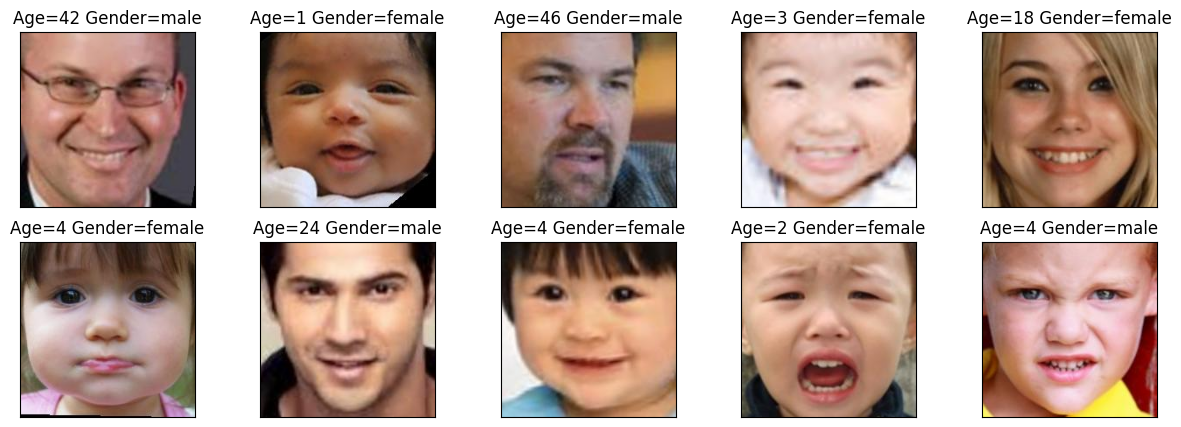

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Age={df['age'][i]} Gender={gender_dict[df['gender'][i]]}")
    image = Image.open(f'/content/crop_part1/{df["img"][i]}')  # Corrected file path formatting
    plt.imshow(image)


plt.show()

<ipython-input-15-90901d642eb4>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age'])


<Axes: xlabel='age', ylabel='Density'>

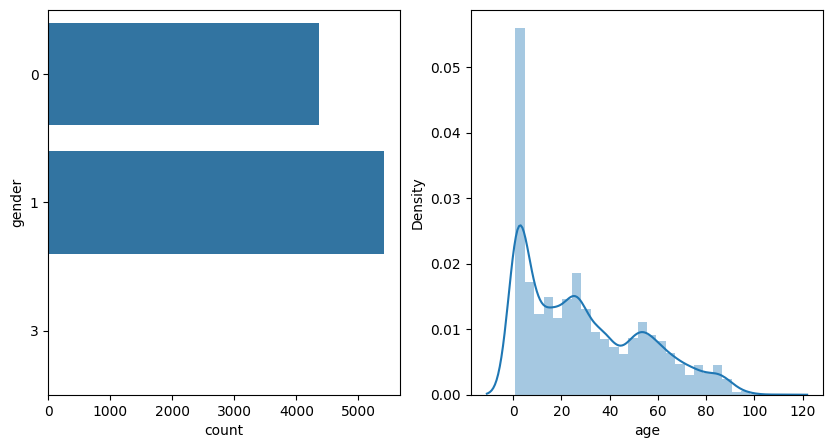

In [15]:
import seaborn as sns
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(df['gender'])
plt.subplot(1,2,2)
sns.distplot(df['age'])

In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
features = []

for image in tqdm(df['img']):
    img = load_img(f'/content/crop_part1/{image}', grayscale = True)
    img = img.resize((200,200), Image.ANTIALIAS)
    img = img_to_array(img)
    img = img/255.0
    features.append(img)


features = np.array(features)


  0%|          | 0/9780 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
<ipython-input-16-fd418bf29e0f>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((200,200), Image.ANTIALIAS)
100%|██████████| 9780/9780 [00:06<00:00, 1524.54it/s]


In [17]:
X = features = features.reshape(len(features), 200, 200, 1)
X = X/255.0

In [18]:
gender_array = np.array(df['gender'])
age_arra = np.array(df['age'])

In [44]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


input = Input(shape=(200, 200, 1))

Conv1 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(input)
BatchNorm1 = BatchNormalization()(Conv1)
Max1 = MaxPooling2D(pool_size=(2,2))(BatchNorm1)

Conv2 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(Max1)
BatchNorm2 = BatchNormalization()(Conv2)
Max2 = MaxPooling2D(pool_size=(2,2))(BatchNorm2)

Conv3 = Conv2D(128, kernel_size = (3,3), activation='relu', padding='same')(Max2)
BatchNorm3 = BatchNormalization()(Conv3)
Max3 = MaxPooling2D(pool_size=(2,2))(BatchNorm3)

Conv4 = Conv2D(256, kernel_size = (3,3), activation='relu', padding='same')(Max3)
BatchNorm4 = BatchNormalization()(Conv4)
Max4 = MaxPooling2D(pool_size=(2,2))(BatchNorm4)

flat = Flatten()(Max4)

# First dense pathway
dense1 = Dense(186, activation='relu')(flat)
dense11 = Dense(64, activation='relu')(dense1)


# Second dense pathway
dense2 = Dense(256, activation='ELU')(flat)
dropout_1 = Dropout(0.5)(dense2)
dense22 = Dense(180, activation='ELU')(dropout_1)
dense222 = Dense(150, activation='ELU')(dense22)
dense2222 = Dense(100, activation='ELU')(dense222)
dropout_2 = Dropout(0.5)(dense2222)
dense22222 = Dense(64, activation='ELU')(dropout_2)

# Dropout for regularization
dropout1 = Dropout(0.5)(dense11)
dropout2 = Dropout(0.5)(dense22222)

# Output layers
output1 = Dense(1, activation='sigmoid', name='gender_output')(dropout1)
output2 = Dense(1, activation='linear', name='age_output')(dropout2)

model = Model(inputs=input, outputs=[output1, output2])
# Compile the model with a lower learning rate
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=['binary_crossentropy', 'mae'], metrics=['accuracy'])


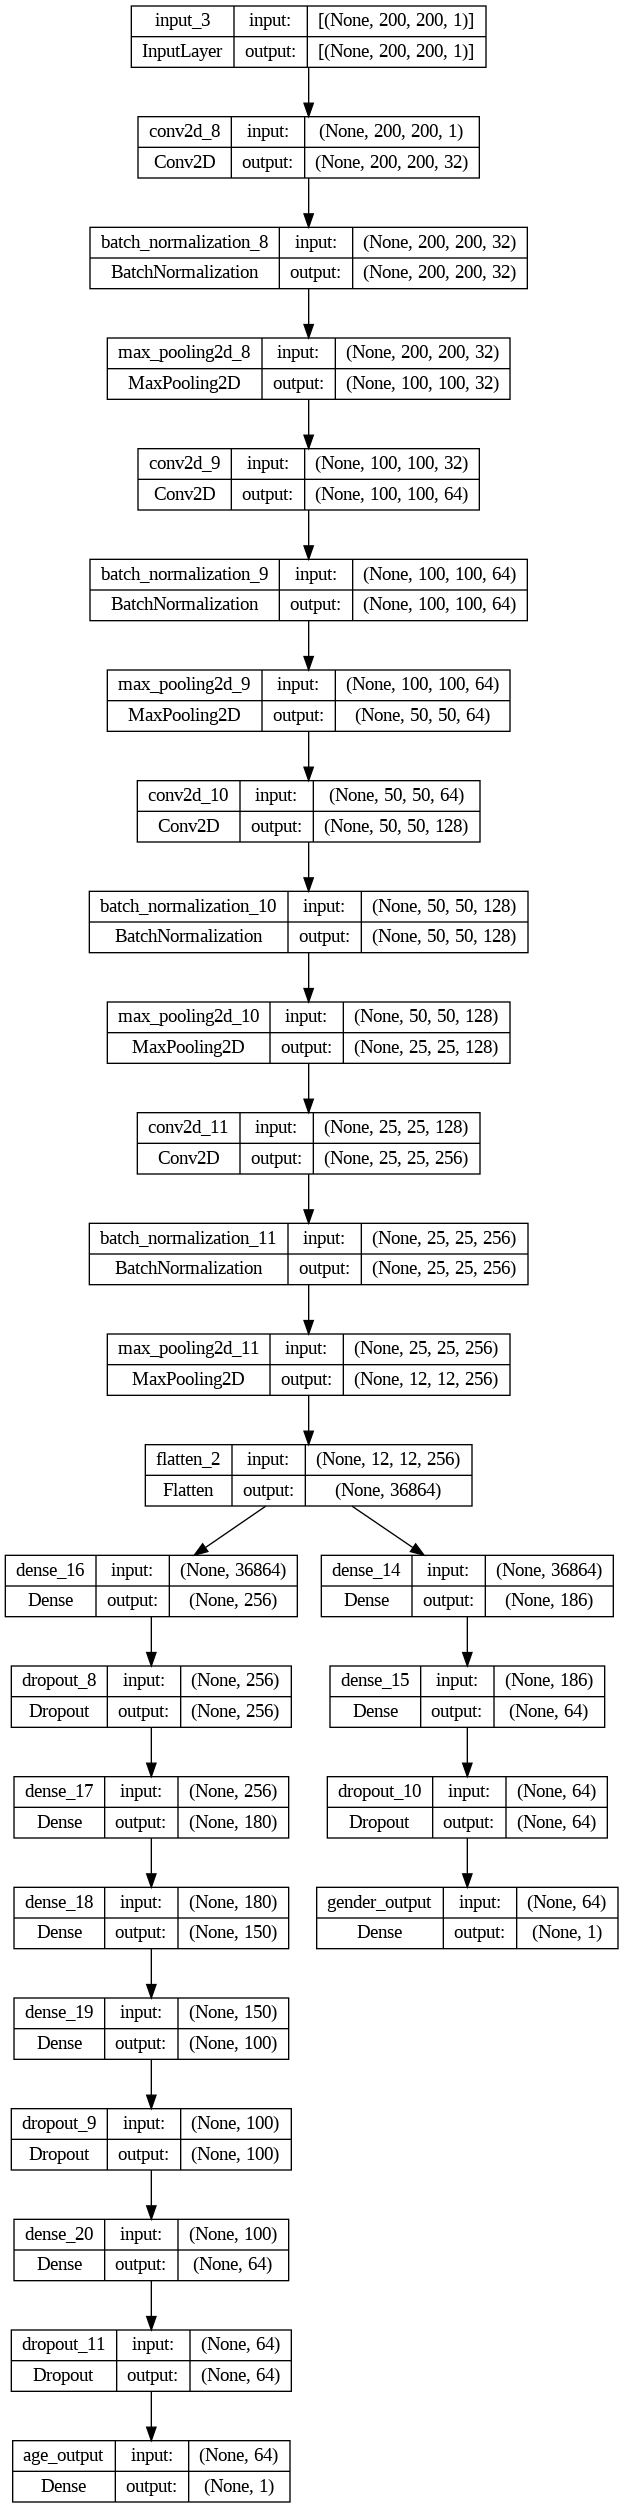

In [45]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [46]:
# Convert gender_array to numeric type before fitting the model
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
gender_array = le.fit_transform(gender_array)

# Convert age_arra to numeric type before fitting the model
age_arra = age_arra.astype(np.float32)  # Or np.int32 if your ages are integers

history = model.fit(x = X, y = [gender_array, age_arra], batch_size=32, epochs=30, validation_split=0.25)

Epoch 1/30
230/230 [==============================] - 22s 75ms/step - loss: 18.2633 - gender_output_loss: 0.6181 - age_output_loss: 17.6453 - gender_output_accuracy: 0.6832 - age_output_accuracy: 0.0867 - val_loss: 30.2050 - val_gender_output_loss: 0.6873 - val_age_output_loss: 29.5176 - val_gender_output_accuracy: 0.5603 - val_age_output_accuracy: 0.0000e+00
Epoch 2/30
230/230 [==============================] - 17s 76ms/step - loss: 13.9397 - gender_output_loss: 0.4754 - age_output_loss: 13.4643 - gender_output_accuracy: 0.7607 - age_output_accuracy: 0.0795 - val_loss: 29.6047 - val_gender_output_loss: 0.7579 - val_age_output_loss: 28.8468 - val_gender_output_accuracy: 0.4397 - val_age_output_accuracy: 4.0900e-04
Epoch 3/30
230/230 [==============================] - 16s 70ms/step - loss: 12.4505 - gender_output_loss: 0.4220 - age_output_loss: 12.0285 - gender_output_accuracy: 0.7988 - age_output_accuracy: 0.0814 - val_loss: 14.6383 - val_gender_output_loss: 0.4623 - val_age_output_los

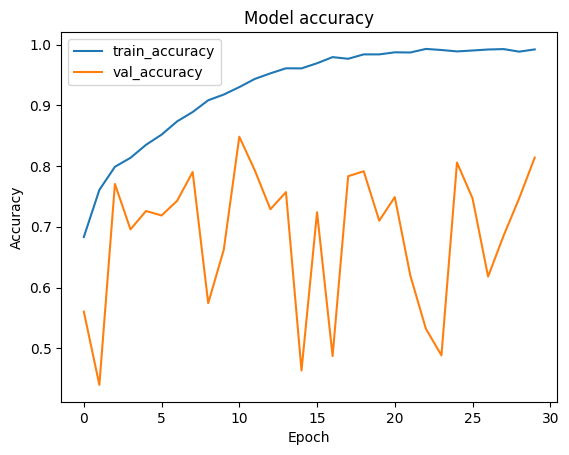

In [47]:
plt.plot(history.history['gender_output_accuracy'], label='train_accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='val_accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

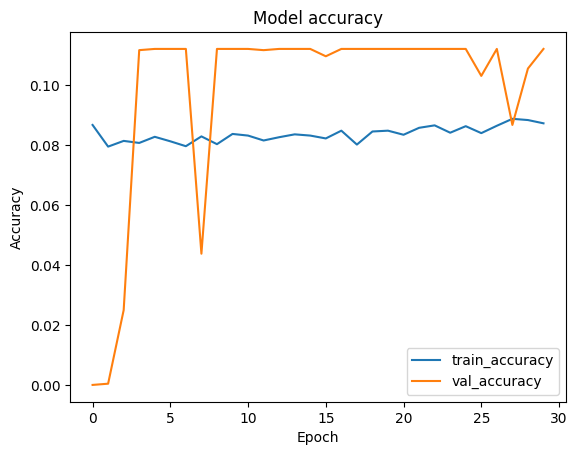

In [48]:
plt.plot(history.history['age_output_accuracy'], label='train_accuracy')
plt.plot(history.history['val_age_output_accuracy'], label='val_accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Original

Gender : female
Age : 1

Pridicted

1/1 [==============================] - 0s 172ms/step
Gender : female
Age : 2



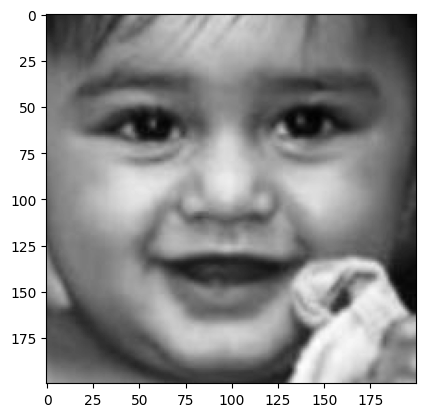

In [49]:
print("Original\n")
index = 100;
plt.imshow(X[index].reshape(200,200), cmap='gray')
print(f"Gender : {gender_dict[df['gender'][index]]}")
print(f"Age : {df['age'][index]}")

print("\nPridicted\n")
pred = model.predict(X[index].reshape(1,200,200,1))
print(f"Gender : {gender_dict[str(round(pred[0][0][0]))]}")
print(f"Age : {round(pred[1][0][0])}\n")

In [53]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path):
    # Load the image
    image = load_img(image_path, target_size=(200, 200), color_mode='grayscale')
    plt.imshow(image)
    # Convert the image to array
    image = img_to_array(image)
    # Normalize the image
    image = image / 255.0
    # Expand dimensions to match the input shape (1, 128, 128, 1)
    image = np.expand_dims(image, axis=0)
    return image

def predict_gender_and_age(model, image_path):
    # Preprocess the image
    image = load_and_preprocess_image(image_path)
    # Predict using the model
    gender_pred, age_pred = model.predict(image)
    print(model.predict(image))
    # Decode the predictions
    gender = 'Male' if gender_pred[0][0] > 0.5 else 'Female'
    age = age_pred[0][0]

    # Display the image and predictions
    # plt.imshow(load_img(image_path))
    plt.title(f"Predicted Gender: {gender}, Predicted Age: {age:.1f}")
    plt.axis('off')
    plt.show()

    return gender, age



1/1 [==============================] - 0s 20ms/step
[array([[0.]], dtype=float32), array([[41.456524]], dtype=float32)]


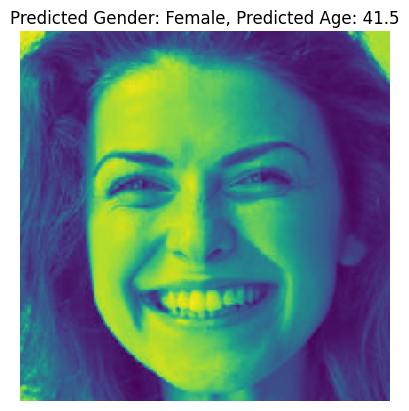

Predicted Gender: Female
Predicted Age: 41.5


In [51]:
image_path = '/content/pexels-photo-774909.png'
gender, age = predict_gender_and_age(model, image_path)
print(f"Predicted Gender: {gender}")
print(f"Predicted Age: {age:.1f}")


In [55]:
import tensorflow as tf
model.save('model.h5')
print("Model saved successfully.")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


Model loaded successfully.
1/1 [==============================] - 0s 179ms/step
Predictions:
  Age : 41 Gender : Female


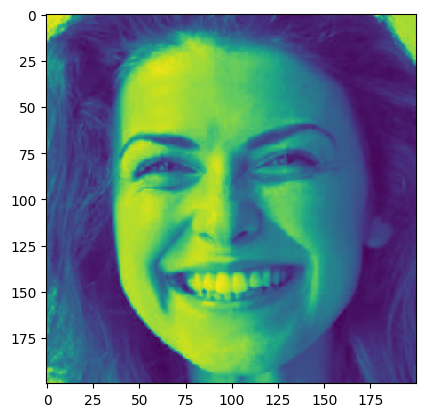

In [63]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the model
model = tf.keras.models.load_model('model.h5')
print("Model loaded successfully.")

# Function to preprocess the image
def preprocess_image(image_path, target_size):
    img = image.load_img(image_path, target_size=target_size, color_mode='grayscale')
    plt.imshow(img)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image
    return img_array

# Path to your image
image_path = '/content/pexels-photo-774909.png'

# Preprocess the image
input_image = preprocess_image(image_path, target_size=(200, 200))  # Adjust target_size to match your model's input size

# Make predictions
predictions = model.predict(input_image)
gender = 'Male' if predictions[0][0] > 0.5 else 'Female'
age = round(predictions[1][0][0])
print(f"Predictions:\n  Age : {age} Gender : {gender}")
